# On Random Number Generation

<span style="font-size: 12px; color: #777; float: right;">This cell contains Latex macros.</span>
$$
\newcommand{\ket}[1]{| #1 \rangle}
\newcommand{\bra}[1]{\langle #1 |}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from package.cqt_rng.simulators.boson_sampler import BosonSampler
from package.cqt_rng.utils.study_boson_sampler import study_boson_sampler, plot_probs
from package.cqt_rng.utils.constants import shi_input_dict, shi_unitary5
from package.cqt_rng.utils.generate_haar_unitary import generate_haar_unitary

### Content:
* [Why do we need RNG?](#Why-do-we-need-RNG?)

## Why do we need RNG?

### Science

### Cryptography

## The problem at hand

We saw how important it is to generate random numbers. Our task is to find a procedure that generates **uniform, unbiased, unreproducible random numbers with a sufficient rate**.

## Making an RNG device

We can decompose the process of generating random numbers into two part:
1. **Entropy source**: The entropy source generates a sample of random numbers. The sample doesn't need to be uniform, we just expect it to be **truly random** and **unreproducible**.
1. **The post-processor**: The post-processor takes a sample of random numbers and outputs a bitstring which should be **uniform**.

Applying the post-processor on the samples taken from entropy source should guarantee that our final output is: **truly random, unreproducible and uniform**.

### The entropy source

#### Classical RNG: (Pseudo-RNG)

In python, it is fairly easy to generate random numbers thanks to package like `random` and `numpy`.

In [10]:
np.random.randint(0, 2, size = 10)

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

But, how random are these numbers? The output above looks pretty random, so did we solve our problem already? No, `numpy` and other classical solutions generate numbers which are **approximately random**. These numbers might be useful in a variety of applications but not in **critical applications** like security and science.

Let's try to understand how `numpy` generate its random numbers. For this, let's pick an [oversimplified algorithm](https://en.wikipedia.org/wiki/Pseudorandom_number_generator#Implementation).

In [65]:
def prng(seed, size):
    bitstring = np.empty(size, dtype=int)
    a, b = 17, 19 # a and b need to be prime numbers
    
    for i in range(size):
        num = seed * a
        bitstring[i] = np.round((num**3 % b) / b)
        seed += 1
        
    return bitstring

And generate a bitstring of length 95:

In [61]:
prng(42, 19 * 5)

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

This looks pretty random doesn't it? However, it is **not**:

1. Everyone who knows your algorithm and knows the initial state (the seed) would be able to **reproduce** your results.

In [68]:
prng(42, 19 * 5) # same output

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

2. If you look closely you will see that their is a pattern that get's repeated:

In [62]:
np.reshape(_, (5, 19))

array([[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]])

You can check that the same happens with numpy, let's pick the seed to be `12` and run `np.random.randint`. On my PC, I get: `array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])`. Try it on your PC, you would get the same results. This means that if their is a breach which would allow someone to know your `seed`. That person can easily reproduce all the random numbers you generate.

In [43]:
np.random.seed(12)
np.random.randint(0, 2, size = 10)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])

Of course, there exists more advanced algorithm's to generate random numbers but generating **truly random** numbers using a classical computer is impossible. This means that we need to change paradigm. We should use a **Quantum** computer to solve our problem. 

Indeed, a key property of quantum system is the **randomness of the measurements** as long as the quantum state isn't in an eigenstate of the measured observable. 

So, to make a **truly random and unreproducible** entropy source. We should:
1. Pick a quantum system. 
1. Make sure that the system is a superposition.
1. Carry a measurement.
1. And we would obtain **truly random** and **unreproducible** results.

Let's see two examples of quantum systems which can be used:

#### Quantum RNG: Qubits

A qubit is any two-states (state $\ket{0}$ and state $\ket{1}$) quantum system. We can apply a superposing gate on a $\ket{0}$-state qubit (for example: the hadamard $H$ or the rotation on y-axis $R_y(\theta)$). To obtain, a quantum state:

$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$$

Then, after making a measurement, we would obtain $0$ with probability $|\alpha|^2$ and $1$ with probability $|\beta|^2$.

This is a theoretically very simple schema to generate random numbers. Yet, it is complex to carry experimentally.

#### Quantum RNG: Boson Sampling

Boson sampling is reminiscent of a [Galton's board](https://en.wikipedia.org/wiki/Galton_board). A Galton's Board is a vertical board in which we drop balls from the top, let them go through an array of pegs and collect them into bins at the bottom. 

<img src="https://i.imgur.com/U05YsTk.png" style="max-height: 300px;"/>
<span style="font-size: 12px; float: right;"><a href="https://research.ibm.com/haifa/ponderthis/challenges/December2021.html">source</a></span>

In a boson sampling experiment, we send a single photon (or more) into an $M$-mode interferometer (which is an array of phase gates and beamsplitters), and then we measure from where it leaves the interferometer.

<img src="https://i.imgur.com/jEdggIq.png/" style="max-height: 300px;">
<span style="font-size: 12px; float: right;"><a href="https://quantum-journal.org/papers/q-2019-08-05-169/">source</a></span>

The photon(s) at the end of the interferometer is(are) _generally_ in a superposition of states. The probability to find $n$-photons at the $m$-detector is a [computationally complex problem](https://strawberryfields.ai/photonics/demos/run_boson_sampling.html) but we know that (apart from some exceptions) the probability is not uniform as you can see from the following figure. The advantage of the boson sampling approach is that it is a rather simple experiment as it only requires phase gates and beamsplitters in comparaison to a gate-based approach.

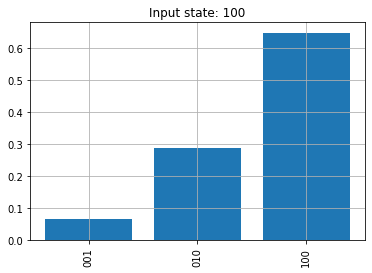

In [4]:
# Probability distribution of sending a photon in the 1st mode through a haar random unitary
probs_bs1 = BosonSampler.get_theo_prob({"100": 1}, generate_haar_unitary(3))
plot_probs(probs_bs1)

### The post-processing

As we already stated above, the output of the entropy source is not expected to be uniform (e.g: the boson sampling experiment). So, we need to carry a post-processing to obtain a uniform and unbiased random output.

#### The post-processing steps:

Given two samples $s_1$ and $s_2$. We would build our uniform bitstring by:
1. Appending $0$ to our bitstring whenever the i-th element of the sample $s_1$ is greater or equal $1$ and the i-th element of the sample $s_2$ is equal to $0$.
2. Appending $1$ to our bitstring whenever the i-th element of the sample $s_1$ is equal to $1$ and the i-th element of the sample $s_2$ is greater or equal $1$.

#### The theory behind post-processing: independent elements

Let's assume that we have sample $S$  from an arbitrary (discrete) distribution. The probability that an element of $S$ is equal to 0 is noted $p$. The probability that an element of $S$ is not equal to $0$ is then $1 - p$. Every element from the sample is independent from the others.


We can split that sample $S$ into two samples $V$ and $W$. We know that the samples $V$ and $W$ **should follow the same distribution** as the sample $S$.

##### The probability of appending 0 to the bitstring:

To append $0$ to the bitstring the $V_i \geq 1$ and $W_i = 0$. Where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i \geq 1) = 1 - p \quad P(W_i = 0) = p$$


Thus, the probability to append $0$ is:

$$ P(V_i \geq 1 \text{ and } W_i = 0) = (1 - p) \; p$$

##### The probability of appending 1 to the bitstring:

To append $1$ to the bitstring the $V_i = 0$ and $W_i \geq 1$. Where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i  = 0) = p \quad P(W_i \geq 0) = 1 - p$$


Thus, the probability to append $1$ is:

$$ P(V_i  = 0 \text{ and } W_i \geq 0) = (1 - p) \; p$$


We can see that the probability that we append $0$ is equal to the probability to append $1$ and thus despite starting with a distribution far from being uniform. We can reach a uniform one.

$$ P(\text{ append } 0) =  P(\text{ append } 1) = (1 - p) \; p$$

##### The probability of discarding the i-th element:
We are also interested in knowing the probability of discarding the $i$-th element as this would impact the rate and cost of our random number generator.

$$ P(\text{ discarding the i-th element }) =  1 - P(\text{ appending } 0) - P(\text{ appending } 1) = 1 - 2p + 2p^2$$

To minimize this probability, We need: $p = 0.5$. As can be checked by looking at the following plot:

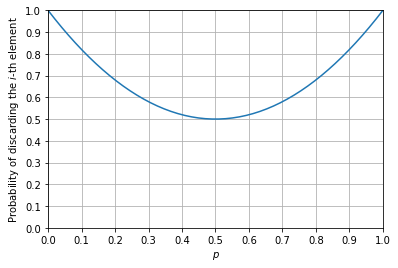

In [93]:
p = np.linspace(0, 1)
plt.plot(p, 1 - 2 * p + 2 * p**2)
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r"$p$")
plt.ylabel(r"Probability of discarding the $i$-th element")
plt.show()

Knowing this, we can for example try to maximize the efficienty of our random number generator by configuring it (as long as it is possible) to have $p = 0.5$.

For the Qubit-based system, this can be done by applying the hadamard gate on our initial $\ket{0}$ qubit. We would obtain:

$$p = P(0) = P(1) = 0.5$$

And we would be able to harness half of our generated sample to get a random bitstring.

If we apply an $R_y$ gate, for example, with angle $\pi / 5$, we would have:

In [86]:
p = np.cos(np.pi / 10)**2

$$p = P(0) = \cos\left(\frac{\pi / 5}{2}\right)^2 \approx 0.90 $$

In [87]:
1 - 2 * p + 2 * p**2

0.8272542485937366

And we would loose 82.7% of our sample, which is a considerable lost.

#### Post-processing: dependent elements

Let's now assume that the element of our sample $S$ are not independent from one another, in this case the theory becomes more complicated. So, in the interest of time and clarity, let's proceed through examples and observations.

##### Example 01:

Let's assume that we are carrying a boson sampling experiment by sending 2 photons through a 2-mode interferometer.

The possible output that can be detected are: $[1, 1], [2, 0], [0, 2]$ where the first number in the list indicates the number of photons detected in the first detector and the second number indicates the number of photons detected in the second detector.

Let's also assume that the probability to obtain $[1, 1]$ is noted $p_1$, the probability to obtain $[2, 0]$ is $p_2$ and the probability to obtain $[0, 2]$ is $p_3$.

Let's assume that we carried a series of this experiement and obtain a sample of results $S$ and we are interested in the probability to append $0$ and $1$ if we follow the post-processing discussed above.

| $V_i$    | $W_i$    | Probability | Post-processed bitstring |
|----------|----------|-------------|--------------------------|
| $[1, 1]$ | $[1, 1]$ | $p_1^2$     | $[]$                     |
| $[1, 1]$ | $[2, 0]$ | $p_1 p_2$   | $[0]$                    |
| $[1, 1]$ | $[0, 2]$ | $p_1 p_3$   | $[0]$                    |
| $[2, 0]$ | $[1, 1]$ | $p_2 p_1$   | $[1]$                    |
| $[2, 0]$ | $[2, 0]$ | $p_2^2$     | $[]$                     |
| $[2, 0]$ | $[0, 2]$ | $p_2 p_3$   | $[0, 1]$                 |
| $[0, 2]$ | $[1, 1]$ | $p_3 p_1$   | $[1]$                    |
| $[0, 2]$ | $[2, 0]$ | $p_3 p_2$   | $[1, 0]$                 |
| $[0, 2]$ | $[0, 2]$ | $p_3^2$     | $[]$                     |

As we can see, we can append $0$ and $1$ to our bitstring, but we can also append $01$ or $10$. 

Now, for the bitstring to be truly unbiased the probability of having $0$ or $1$ should be equal BUT ALSO the probability to have $00$, $01$, $10$, $11$ should be equal (and the same applies for longer combinations of 0,1).  An illustration of a bitstring where the $P(0) = P(1)$ but the bitstring is not random is this $01010101$. We can see that $P(0) = P(1)$ but given that we know that the $i$-th is $0$ we are guaranteed that the $i+1$-th bit is 1 and vice versa. A bias might be more suble where given that we know that the $i$-th is a certain value there is unequal probabilities for $i+1$-th bit to be $0$ or $1$.

**Is $P(00) = P(01)$ for the sampling experiment above?**

$$P(0) = p_1 p_2 + p_1 p_3 - p_1 p_2 p_3 \qquad P(1) = p_2 p_1 + p_3 p_1 - p_1 p_2 p_3$$

So, $$P(0) = P(1)$$. Let's check $P(00)$ and $P(01)$:
$$P(00) = P(0) \; P(0) \qquad P(01) = P(0) \; P(1) + p_2 p_3$$

In [94]:
def p_0(p1, p2):
    p3 = 1 - p1 - p2
    return p1 * p2 + p2 * p3 - p1 * p2 * p3

In [95]:
def p_1(p1, p2):
    p3 = 1 - p1 - p2
    return p1 * p2 + p2 * p3 - p1 * p2 * p3

In [96]:
def p_00(p1, p2):
    return p_0(p1, p2)**2

In [97]:
def p_01(p1, p2):
    p3 = 1 - p1 - p2
    return p_0(p1, p2) * p_1(p1, p2) + p2 * p3

In [105]:
def diff_p00_p01(p1, p2):
    return  p_00(p1, p2) - p_01(p1, p2)

In [106]:
p1 = np.linspace(0, 1)
p2 = np.linspace(0, 1)
mp1, mp2 = np.meshgrid(p1, p2)

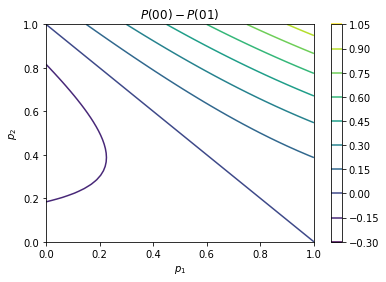

In [121]:
plt.contour(mp1, mp2, diff_p00_p01(mp1, mp2), levels=10)
plt.colorbar()
plt.xlabel("$p_1$")
plt.ylabel("$p_2$")
plt.title("$P(00) - P(01)$")
plt.show()

As we can see unless the $p_i$ are fine-tuned, the probabilities of having $00$, $01$ in this example are unequal, which introduces some bias. 

Let's now see what is the probability of not appending anything to our bitstring.

##### Example 02:

Let's try to go a level harder and try to understand the output (after post-processing) of the [Shi et al. experiment](#References).

In this experiment (and as far as we understood), we are sending two photons into a 5-mode interferometer and collecting the results. We implemented a boson sampling simulator which we can use to to carry this experiment and study the output.

In [2]:
probs_ex2 = BosonSampler.get_theo_prob(shi_input_dict, shi_unitary5)

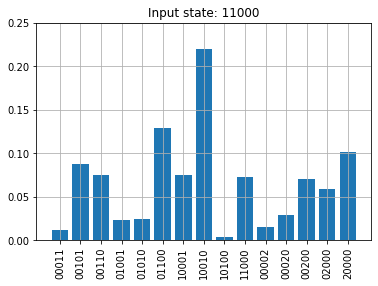

In [3]:
plot_probs(probs_ex2)

As you can see, we retrieve the same probability distribution as in figure 4. (a). Now, let's see what we would obtain we we draw random samples from this distribution and postprocess them:

In [4]:
study_boson_sampler(probs_ex2)

{'': 0.11076034842265559,
 '01': 0.15623248357924951,
 '0011': 0.014224687736575177,
 '1': 0.086276322351524,
 '011': 0.046932874437632034,
 '10': 0.15623248357924951,
 '0101': 0.026827344664134764,
 '101': 0.047270433235091926,
 '0110': 0.04746315783366155,
 '110': 0.01938995085106701,
 '1001': 0.04746315783366155,
 '1010': 0.026827344664134764,
 '1100': 0.014224687736575177,
 '0': 0.08627632235152402,
 '001': 0.019389950851067008,
 '010': 0.047270433235091926,
 '100': 0.046932874437632034}

The function `study_boson_sampler` takes the output of `BosonSampler.get_theo_prob` and output a dictionnary whose keys are bitstrings and the values are the probabilities that the bitstring gets appended to our final bitstring. 

As we can see the probability that nothing gets appended to the bitstring is very low 11% compared the minimal 50% for previous case. But, this comes at price which is that in the general case unless we choose our unitary very carefully there would be a small bias in our final bitstring because if we calculate.

##### Example 03:

Let's look at another example in which the bias is more clear. Let's pick a 10-mode interferometer and send either two-photons in the 5th and 6th mode or in the 4th and 7th mode with probability 50% for each (look at the `ex3_input` below).

In [5]:
from scipy.linalg import block_diag
ex3_input = {"0000110000": 0.5, "0001001000": 0.5}
ex3_unitary = block_diag(shi_unitary5[:, ::-1], shi_unitary5)

In [7]:
probs_ex3 = BosonSampler.get_theo_prob(ex3_input, ex3_unitary)

In [8]:
study_boson_sampler(probs_ex3)

{'': 0.0582240772333743,
 '01': 0.1830735048886352,
 '0101': 0.14390914285283732,
 '10': 0.1830735048886353,
 '0110': 0.14390914285283737,
 '1001': 0.14390914285283737,
 '1010': 0.14390914285283732}

As you can see here, the bias in the bitstring would be more obvious in this case. Given a bitstring generated with such an input and unitary. If we have $00$, we are certain that the next bit would be a $1$ and vice versa.

#### Post-processing: dependent elements, the unbiased way

As we just saw, if we have a sample whose elements are dependent, we can generate bitstrings with less losses but at the cost of introducing suble (or less suble) biases. If we only care about having an unbiased bitstring at the cost of rate. We would make two postprocessings. In the first one, we would obtain results similar to the postprocessing described above, then if the obtain bitstring starts with a $0$ we would append $0$ to our final bitstring and if the bitstring starts with $1$, we would append $1$ to our final bitstring.

This way, we guarentee that our final bitstring is free from all biases.

## Testing the randomness

## The CQT RNG package

### The package architecture

### Shi et al. Simulator(s)

### Qubits-based Simulator

### Real Devices: IBMQ

### Real Devices: Borealis

## Conclusions

In [10]:
from package.cqt_rng.base.rng import RNG

In [11]:
from package.cqt_rng.simulators.qubits_sampler import QubitsSampler

In [12]:
from package.cqt_rng.simulators.shi_sampler import ShiSampler

In [13]:
from scipy.linalg import block_diag

In [14]:
rng1 = RNG(entropy_source=QubitsSampler())

In [15]:
rng1.generate(24)

27it [00:00, 192.62it/s]                                                        


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0])

In [16]:
unitary5 = ShiSampler.generate_haar_unitary(5)
unitary10 = block_diag(unitary5, unitary5.T)

In [17]:
# rng2 = RNG(entropy_source=ShiSampler(unitary = unitary10))

In [18]:
# rng2.generate(10)

In [19]:
unitary3 = ShiSampler.generate_haar_unitary(3)

In [20]:
rng3 = RNG(entropy_source=ShiSampler(with_sf = True, unitary = unitary3))

In [21]:
# rng3.generate(20)

In [37]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.tools.monitor import job_monitor

In [38]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 1 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-08-17 22:08:17,913: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila


In [39]:
nb_qubits = backend.configuration().n_qubits

print(f"Running the job on {backend} with {nb_qubits} qubits!")

qc = QuantumCircuit(nb_qubits)

for i in range(nb_qubits):
    qc.h(i)
    
qc.measure_all()

Running the job on ibmq_manila with 5 qubits!


In [45]:
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, memory=True)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [46]:
results = job.result()

In [47]:
results.get_memory()

['10100',
 '00101',
 '01000',
 '00100',
 '10110',
 '10100',
 '01100',
 '10010',
 '10010',
 '11001',
 '11010',
 '10000',
 '00100',
 '10110',
 '10110',
 '01010',
 '11010',
 '10100',
 '00001',
 '01010',
 '11010',
 '11100',
 '10110',
 '01111',
 '01001',
 '00111',
 '11111',
 '10010',
 '11000',
 '01000',
 '00001',
 '00011',
 '10011',
 '11111',
 '01011',
 '11110',
 '11101',
 '11011',
 '11000',
 '01000',
 '01100',
 '00111',
 '11001',
 '01001',
 '10001',
 '11011',
 '00000',
 '11001',
 '01000',
 '00011',
 '00011',
 '10101',
 '10100',
 '10111',
 '11100',
 '00100',
 '10001',
 '10010',
 '01001',
 '11100',
 '00000',
 '10010',
 '01111',
 '01000',
 '10110',
 '10101',
 '11100',
 '00000',
 '00001',
 '00101',
 '10110',
 '01010',
 '10011',
 '00111',
 '11101',
 '00100',
 '00110',
 '11010',
 '10100',
 '00101',
 '00110',
 '11111',
 '00011',
 '10001',
 '11010',
 '00101',
 '11001',
 '01111',
 '11100',
 '00101',
 '10011',
 '10010',
 '11011',
 '00101',
 '00000',
 '00100',
 '00000',
 '00001',
 '00101',
 '01011',


In [54]:
bitstring_str = "".join(results.get_memory())

In [56]:
data_arr = np.array(list(bitstring_str)).astype(int)

In [58]:
s1 = data_arr[:10000]

In [59]:
s2 = data_arr[10000:]

In [61]:
np.size(s2)

10000

In [64]:
def postprocess(sample_1, sample_2):
    """
        TODO: Von-Neumann post-processing
    """
    bitstring = []
    for bit_1, bit_2 in zip(sample_1, sample_2):
        if bit_1 == 0 and bit_2 != 0:
            bitstring.append(1)
        elif  bit_1 != 0 and bit_2 == 0:
            bitstring.append(0)

    return bitstring

In [65]:
rng = postprocess(s1, s2)

In [67]:
np.size(rng)

5016

In [68]:
def bitstring_to_8b_nbs(bitstring):
    """
    Transform the 01 bitstring into char numbers (8bits)
    """
    bs = np.copy(bitstring)
    diff = 8 - (np.size(bs) % 8)
    bs = np.pad(bs, (0, diff), 'constant', constant_values=2)
    r = np.size(bs) // 8
    cropped_bs = np.resize(bs, (r, 8))[:-1, :]
    useful_r = r - 1 if diff else r 
    res = []
    for i in range(useful_r):
        d = int("".join(cropped_bs[i, :].astype(str)), 2)    
        res.append(d)
    return np.array(res)

In [69]:
rng_8b = bitstring_to_8b_nbs(rng)

In [73]:
import nistrng

def nist_tests(bitstring):
    # Check the eligibility of the test and generate an eligible battery from the default NIST-sp800-22r1a battery
    eligible_battery: dict = nistrng.check_eligibility_all_battery(bitstring, nistrng.SP800_22R1A_BATTERY)
    # Print the eligible tests
    print("Eligible test from NIST-SP800-22r1a:")
    for name in eligible_battery.keys():
        print("-" + name)
    # Test the result on the eligible tests
    results = nistrng.run_all_battery(bitstring, eligible_battery, False)
    # Print results one by one
    print("Test results:")
    failed = 0
    for result, elapsed_time in results:
        if result.passed:
            print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
        else:
            failed += 1
            print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    print(f"Total failed tests: {failed}/{len(eligible_battery.keys())}")

In [72]:
print(f"The percentage of 1 bits: {np.sum(rng) * 100 / 5016}%")

The percentage of 1 bits: 49.04306220095694%


In [75]:
nist_tests(np.array(rng))

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-dft
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
-random_excursion
-random_excursion_variant
Test results:
- PASSED - score: 0.175 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.144 - Frequency Within Block - elapsed time: 2 ms
- PASSED - score: 0.629 - Runs - elapsed time: 6 ms
- PASSED - score: 0.368 - Longest Run Ones In A Block - elapsed time: 0 ms
- PASSED - score: 0.14 - Discrete Fourier Transform - elapsed time: 5 ms
- PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 22 ms
- PASSED - score: 0.422 - Serial - elapsed time: 148 ms
- PASSED - score: 0.181 - Approximate Entropy - elapsed time: 116 ms
- PASSED - score: 0.198 - Cumulative Sums - elapsed time: 5 ms
- FAILED - score: 0.079 - Random Excursion - elapsed time: 23 ms
- PASSED - score: 0.562 - Random Excursion Variant - elapsed time: 2 ms
Total failed tests: 1

## References